# Nishika 日本酒銘柄画像検索 チュートリアル

[日本酒銘柄画像検索のチュートリアル実践ファイル](https://competition.nishika.com/competitions/sake/topics/588)

In [1]:
!nvidia-smi

Thu Jun 29 15:35:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:17:00.0 Off |                  Off |
| 30%   59C    P0    82W / 300W |      0MiB / 48682MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    Off  | 00000000:65:00.0 Off |                  Off |
| 34%   

In [2]:
import collections
import math
import os
import random
import typing
from pathlib import Path

import faiss
import japanize_matplotlib
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch.nn import CrossEntropyLoss, Parameter
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [3]:
# !pip install japanize_matplotlib
# !pip install missingno
# !pip install timm
# !pip install albumentations

print(os.getcwd())

/home/user/code/src/code


In [4]:
BASE_DIR = Path("../")
DATA_DIR = BASE_DIR.joinpath("data")
FEATURES_DIR = BASE_DIR.joinpath("features")
OUT_DIR = BASE_DIR.joinpath("output")
INDEX_DIR = BASE_DIR.joinpath("index")
MODEL_DIR = BASE_DIR.joinpath("model")
CITE_IMG_DIR = DATA_DIR.joinpath("cite_images")
QUERY_IMG_DIR = DATA_DIR.joinpath("query_images")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EXP_NAME="cpt-sake-tutorial"


class CFG:
    img_size = 224
    model_name = "convnext_base"
    in_channels = 3
    embedding_dim = 128
    pretrained = True
    batch_size = 128
    n_workers = 0
    seed = 0

In [5]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(CFG.seed)

# データ

In [6]:
cite_filepath = DATA_DIR.joinpath("cite.csv")
train_filepath = DATA_DIR.joinpath("train.csv")
test_filepath = DATA_DIR.joinpath("test.csv")
sub_filepath = DATA_DIR.joinpath("sample_submission.csv")
df_cite = pd.read_csv(cite_filepath)
df_train = pd.read_csv(train_filepath)
df_test = pd.read_csv(test_filepath)
df_sub = pd.read_csv(sub_filepath)

## データの形式，概要確認

In [7]:
df_cite.shape

(109481, 2)

In [8]:
df_cite.head()

,cite_gid,cite_filename
0,100000001,100000001.jpg
1,100000002,100000002.jpg
2,100000003,100000003.jpg
3,100000004,100000004.jpg
4,100000005,100000005.jpg


In [9]:
df_cite.isna().sum()

cite_gid         0
cite_filename    0
dtype: int64

In [10]:
df_train.shape

(108160, 4)

In [11]:
df_train.head()

,gid,filename,brand_id,meigara
0,200000001,200000001.jpg,3372,五橋
1,200000002,200000002.jpg,3751,庭のうぐいす
2,200000003,200000003.jpg,2856,笑四季
3,200000004,200000004.jpg,1527,鍋島
4,200000005,200000005.jpg,2676,仙禽


### trainの欠損値確認
`meigara`記述がないものがある
画像を表示させて確認する

In [12]:
df_train.isna().sum()

gid         0
filename    0
brand_id    0
meigara     1
dtype: int64

In [13]:
df_train[df_train['meigara'].isna()]

,gid,filename,brand_id,meigara
9422,200009423,200009423.jpg,2775,NaN


In [14]:
df_train[df_train['meigara'].isna()].filename

9422    200009423.jpg
Name: filename, dtype: object

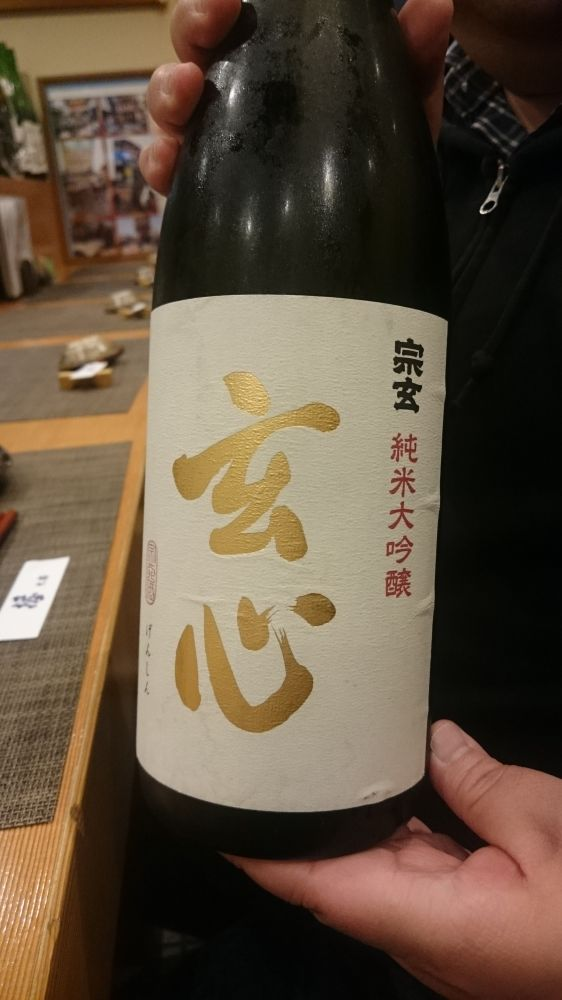

In [15]:
target_path = QUERY_IMG_DIR.joinpath(df_train[df_train['meigara'].isna()].filename.values[0])
image = Image.open(target_path)
image.show()
# print(target_path)

### testデータの確認

In [16]:
df_test.shape

(2942, 2)

In [17]:
df_test.head()

,gid,filename
0,200108161,200108161.jpg
1,200108162,200108162.jpg
2,200108163,200108163.jpg
3,200108164,200108164.jpg
4,200108165,200108165.jpg


In [18]:
df_test.isna().sum()

gid         0
filename    0
dtype: int64

## 提出ファイルの形式確認

In [19]:
df_sub.head()

,gid,cite_gid
0,200108161,100000001 100000002 100000003 100000004 100000...
1,200108162,100000001 100000002 100000003 100000004 100000...
2,200108163,100000001 100000002 100000003 100000004 100000...
3,200108164,100000001 100000002 100000003 100000004 100000...
4,200108165,100000001 100000002 100000003 100000004 100000...


In [20]:
df_sub.dtypes

gid          int64
cite_gid    object
dtype: object

引用画像ID(gid)をスペース区切りで繋いだ文字列を予測結果とする．

In [21]:
pred_sample = df_sub["cite_gid"].values[0]
print(pred_sample)

100000001 100000002 100000003 100000004 100000005 100000006 100000007 100000008 100000009 100000010 100000011 100000012 100000013 100000014 100000015 100000016 100000017 100000018 100000019 100000020


## 画像ファイルのパス情報追加

In [22]:
cite_filenames = df_cite["cite_filename"].to_list()
df_cite["path"] = [str(CITE_IMG_DIR.joinpath(filename)) for filename in cite_filenames]
train_filenames = df_train["filename"].to_list()
df_train["path"] = [str(QUERY_IMG_DIR.joinpath(filename)) for filename in train_filenames]
test_filenames = df_test["filename"].to_list()
df_test["path"] = [str(QUERY_IMG_DIR.joinpath(filename)) for filename in test_filenames]

In [23]:
df_train.head()

,gid,filename,brand_id,meigara,path
0,200000001,200000001.jpg,3372,五橋,../data/query_images/200000001.jpg
1,200000002,200000002.jpg,3751,庭のうぐいす,../data/query_images/200000002.jpg
2,200000003,200000003.jpg,2856,笑四季,../data/query_images/200000003.jpg
3,200000004,200000004.jpg,1527,鍋島,../data/query_images/200000004.jpg
4,200000005,200000005.jpg,2676,仙禽,../data/query_images/200000005.jpg


## 訓練データの brand_id, meigara

訓練データ内のbrand_idの種類数：2515


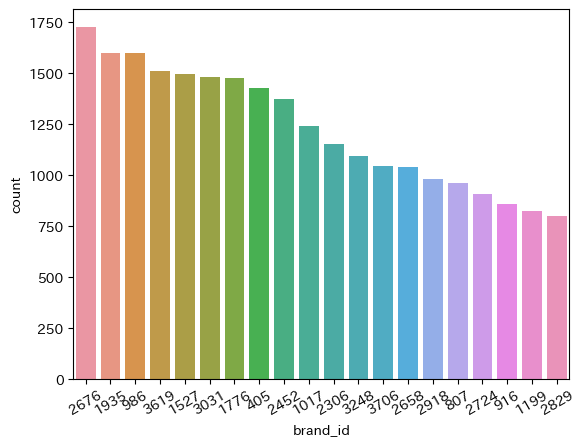

In [24]:
topn = 20
print("訓練データ内のbrand_idの種類数：{:4d}".format(df_train["brand_id"].nunique()))
ax = sns.countplot(x = df_train["brand_id"], order=pd.value_counts(df_train['brand_id']).iloc[:topn].index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

訓練データ内のmeigaraの種類数：2498


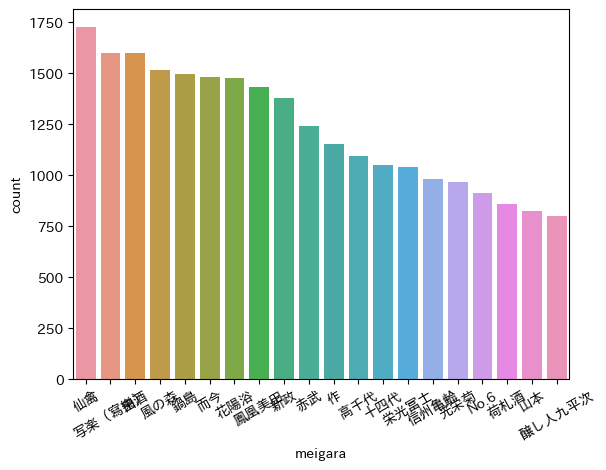

In [25]:
topn = 20
print("訓練データ内のmeigaraの種類数：{:4d}".format(df_train["meigara"].nunique()))
ax = sns.countplot(x = df_train["meigara"], order=pd.value_counts(df_train['meigara']).iloc[:topn].index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

## meigaraが同じ画像サンプルを確認
- meigara: brand_idは多くの場合1:1だが，1:N の場合が一部存在する．
- 別の酒蔵が同じ銘柄の商品を出す場合に別ブランドとして扱われている．

難しい点
- お酒にフォーカスした写真や，料理と一緒に殺絵された写真が混在
- 同じブランドであっても，お酒の容器のラベルレイアウトに複数の種類がある場合がある

In [26]:
df_brand = df_train.groupby('meigara')['brand_id'].nunique().to_frame()
df_brand[df_brand['brand_id'] > 1]

,brand_id
meigara,
BLACK JACK,2
亀の尾,2
初桜,3
千代鶴,2
喜久水,2
喜平,2
御代栄,2
男山,2
白龍,2


In [27]:
df_train[df_train["meigara"] == "初桜"].head()

,gid,filename,brand_id,meigara,path
2194,200002195,200002195.jpg,2339,初桜,../data/query_images/200002195.jpg
3360,200003361,200003361.jpg,2149,初桜,../data/query_images/200003361.jpg
8604,200008605,200008605.jpg,2339,初桜,../data/query_images/200008605.jpg
15880,200015881,200015881.jpg,2339,初桜,../data/query_images/200015881.jpg
18925,200018926,200018926.jpg,2149,初桜,../data/query_images/200018926.jpg


In [28]:
#@title
def show_same_meigara(meigara: str) -> None:
    image_paths = df_train.loc[df_train['meigara'] == meigara, 'path'].to_numpy()
    brand_ids = df_train.loc[df_train['meigara'] == meigara, 'brand_id'].to_numpy()
    col = 2
    # row = int(len(image_paths)/col)
    row = int(len(image_paths)/col)
    
    n_samples = row * col
    fig, axs = plt.subplots(row, col, figsize = (col * 5, row * 5))
    for i, path in enumerate(image_paths[:n_samples]):
        j = int(i / 2)
        k = i % 2
        image = Image.open(path)
        axs[j, k].imshow(image)
        title = f"brand_id: {str(brand_ids[i])}"
        axs[j, k].set_title(title)
        axs[j, k].axis('off')  # 軸を非表示にする
    plt.show()

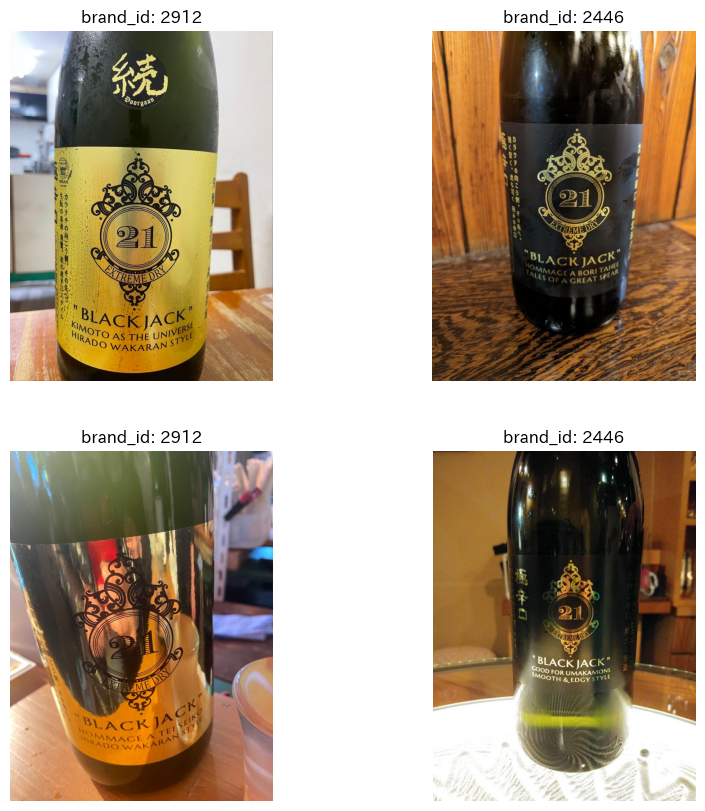

In [29]:
show_same_meigara(meigara = 'BLACK JACK')

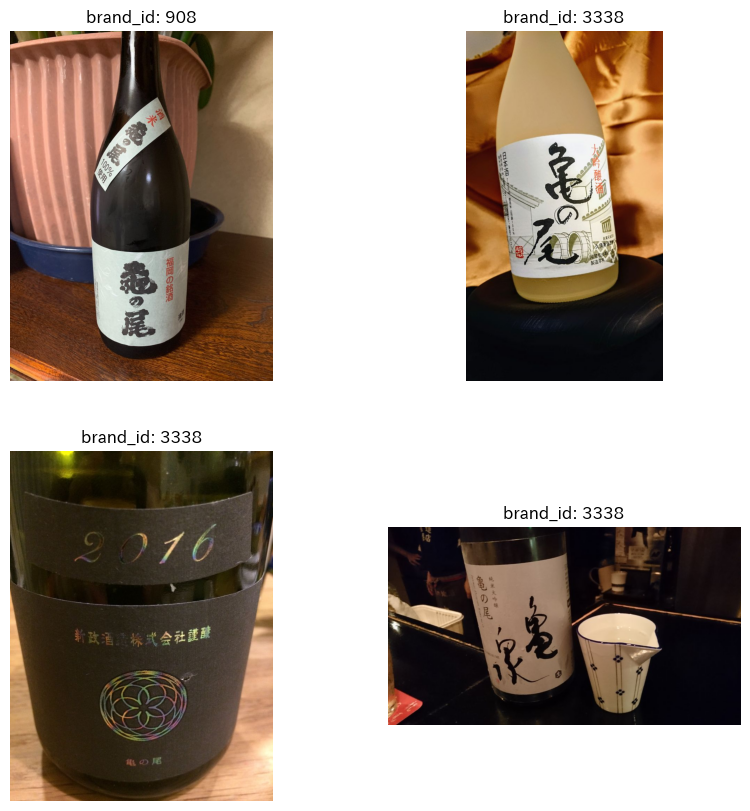

In [30]:
show_same_meigara(meigara = "亀の尾")

# データセット

In [31]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # RGB
IMAGENET_STD = [0.229, 0.224, 0.225]  # RGB

class SakeDataset(Dataset):
    def __init__(self, image_filepaths: list, labels: list = None,
                 transform: typing.Dict[str, typing.Any] =None) -> None:
        self.image_filepaths = image_filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return len(self.image_filepaths)

    def __getitem__(self, idx: int) -> typing.Tuple[torch.tensor, torch.tensor]:
        item = dict()
        image_filepath = self.image_filepaths[idx]
        image = self.__read_image(image_filepath)
        if self.transform is not None:
            image = self.transform(image = image)["image"]
            item["image"] = image

        if self.labels is not None:
            label = self.labels[idx]
            label = torch.tensor(label, dtype = torch.long)
            item["label"] = label
        return item

    def __read_image(self, path: str) -> None:
        with open(path, 'rb') as f:
            image = Image.open(f)
            image_rgb = image.convert('RGB')
        image = np.array(image_rgb)
        return image

def get_transforms(img_size: int = 224) -> torch.tensor:
    return Compose(
        [
            Resize(img_size, img_size),
            Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ToTensorV2()
        ]
  )

# ConvNeXt Base モデルの画像特徴量で検索

In [32]:
class SakeNet(nn.Module):
    def __init__(
        self,
        cfg
    ):
        super().__init__()
        self.cfg = cfg
        if hasattr(timm.models, cfg.model_name):
            base_model = timm.create_model(
                cfg.model_name, num_classes=0, pretrained=cfg.pretrained, in_chans=cfg.in_channels
            )
            in_features = base_model.num_features
            self.backbone = base_model
            print('load imagenet model_name:', cfg.model_name)
            print('load imagenet pretrained:', cfg.pretrained)
        else:
            raise NotImplementedError
        self.in_features = in_features
        self.fc = nn.Linear(self.in_features, cfg.embedding_dim)

    def get_embedding(self, image: torch.tensor) -> torch.tensor:
        output = self.backbone(image)
        output = self.fc(output)
        return output


In [33]:
model = SakeNet(cfg = CFG)
model = model.to(DEVICE)
model_path = MODEL_DIR.joinpath(f'{EXP_NAME}.pth')
torch.save(model.state_dict(), model_path)

load imagenet model_name: convnext_base
load imagenet pretrained: True


# インデックス作成

In [34]:
def infer(data_loader: DataLoader, model: nn.Module) -> np.array:
    stream = tqdm(data_loader)
    model.eval()
    embedding = []
    for batch in stream:
        images = batch["image"].to(DEVICE, non_blocking = True).float()
        # targets = batch["target"].to(DEVICE, non_blocking = True).float().view(-1, 1)
        with torch.set_grad_enabled(mode = False):
            output = model.get_embedding(images)
            embedding.append(output.detach().cpu().numpy())
    embedding = np.concatenate(embedding)
    return embedding


In [35]:
cite_dataset = SakeDataset(
  image_filepaths = df_cite["path"].to_list(),
  transform = get_transforms()
)
cite_loader = DataLoader(
  cite_dataset,
  batch_size = CFG.batch_size,
  shuffle = False,
  num_workers = CFG.n_workers,
  pin_memory = True
)
model = SakeNet(cfg = CFG)
model = model.to(DEVICE)
model.load_state_dict(torch.load(model_path))
cite_embedding = infer(cite_loader, model)

load imagenet model_name: convnext_base
load imagenet pretrained: True


  0%|          | 0/856 [00:00<?, ?it/s]

In [37]:
np.save(FEATURES_DIR.joinpath(f"cite_embedding_{EXP_NAME}.npy"), cite_embedding)

In [38]:
class FaissKNeighbors:
    def __init__(self, model_name: str, index_name: str, k: int = 10) -> None:
        self.index = None
        self.d = None
        self.k = k
        self.model_name = model_name
        self.index_name = str(INDEX_DIR.joinpath(f"{index_name}.index"))

    def fit(self, X: np.array) -> None:
        X = X.copy(order="C")
        self.d = X.shape[1]
        # distance: cosine similarity
        self.index = faiss.IndexFlatIP(self.d)
        self.index.add(X.astype(np.float32))

    def save_index(self) -> None:
        faiss.write_index(self.index, self.index_name)
        print(f"{self.index_name} saved.")

    def read_index(self) -> None:
        self.index = faiss.read_index(self.index_name)
        self.d = self.index.d
        print(f"{self.index_name} read.")

    def predict(self, X: np.array) -> typing.Tuple:
        X = X.copy(order="C")
        X = np.reshape(X, (-1, self.d))
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        if X.shape[0] == 1:
            return distances[0], indices[0]
        else:
            return distances, indices

In [39]:
knn = FaissKNeighbors(model_name =CFG.model_name, index_name = EXP_NAME, k = 20)
knn.fit(cite_embedding)
knn.save_index()

../index/cpt-sake-tutorial.index saved.


In [40]:
df_cite.head()

,cite_gid,cite_filename,path
0,100000001,100000001.jpg,../data/cite_images/100000001.jpg
1,100000002,100000002.jpg,../data/cite_images/100000002.jpg
2,100000003,100000003.jpg,../data/cite_images/100000003.jpg
3,100000004,100000004.jpg,../data/cite_images/100000004.jpg
4,100000005,100000005.jpg,../data/cite_images/100000005.jpg


In [41]:
idx2cite_gid = dict(zip(df_cite.index, df_cite["cite_gid"]))

# クエリ画像の検索

In [42]:
test_dataset = SakeDataset(
  image_filepaths = df_test["path"].to_list(),
  transform = get_transforms()
)
test_loader = DataLoader(
  test_dataset,
  batch_size = CFG.batch_size,
  shuffle = False,
  num_workers = CFG.n_workers,
  pin_memory = True
)

query_embedding = infer(test_loader, model)
np.save(FEATURES_DIR.joinpath(f"query_embedding_{EXP_NAME}.npy"), query_embedding)

  0%|          | 0/23 [00:00<?, ?it/s]

In [43]:
query_embedding = np.load(FEATURES_DIR.joinpath(f"query_embedding_{EXP_NAME}.npy"))
query_embedding.shape

(2942, 128)

In [45]:
cite_gids = []
for _query_embeding in tqdm(query_embedding):
    distance, pred = knn.predict(_query_embeding)
    _cite_gids = [str(idx2cite_gid[p]) for p in pred]
    cite_gids.append(" ".join(_cite_gids))
df_test["cite_gid"] = cite_gids
df_test[["gid", "cite_gid"]].to_csv(OUT_DIR.joinpath(f"submission_{EXP_NAME}.csv"), index = False)

  0%|          | 0/2942 [00:00<?, ?it/s]

In [46]:
#@title
def view_result_bygid(df_test: pd.DataFrame, gid: int) -> None:
    pred_gids = df_test.loc[df_test["gid"] == gid, "cite_gid"].values[0]
    pred_gids = pred_gids.split()

    query_path = df_test.loc[df_test["gid"] == gid, "path"].values[0]
    paths = []
    paths.append(query_path)
    cite_paths = [str(CITE_IMG_DIR.joinpath(path + ".jpg")) for path in pred_gids]
    paths.extend(cite_paths)

    figs, axs = plt.subplots(nrows = 7, ncols = 3, figsize = (10,20))
    for i, path in enumerate(paths):
        img = Image.open(path)
        i_row = int(i / 3)
        i_col = i % 3
        axs[i_row, i_col].imshow(img)
        gid = path.split("/")[-1].replace(".jpg", "")
        if i == 0:
            title = f"query data gid:{gid}"
            color = "red"
        else:
            title = f"rank: {i}, cite_gid:{gid}"
            color = "black"

        axs[i_row, i_col].set_title(title, color = color)
        axs[i_row, i_col].grid(False)
        axs[i_row, i_col].axis("off")
    plt.show()

# 検索結果の確認

In [47]:
df_test.head()

,gid,filename,path,cite_gid
0,200108161,200108161.jpg,../data/query_images/200108161.jpg,100071725 100092725 100025175 100057861 100087...
1,200108162,200108162.jpg,../data/query_images/200108162.jpg,100103726 100104659 100015484 100004873 100102...
2,200108163,200108163.jpg,../data/query_images/200108163.jpg,100025379 100045917 100097204 100075867 100033...
3,200108164,200108164.jpg,../data/query_images/200108164.jpg,100031285 100035860 100043139 100058886 100022...
4,200108165,200108165.jpg,../data/query_images/200108165.jpg,100038021 100036931 100006007 100031023 100096...


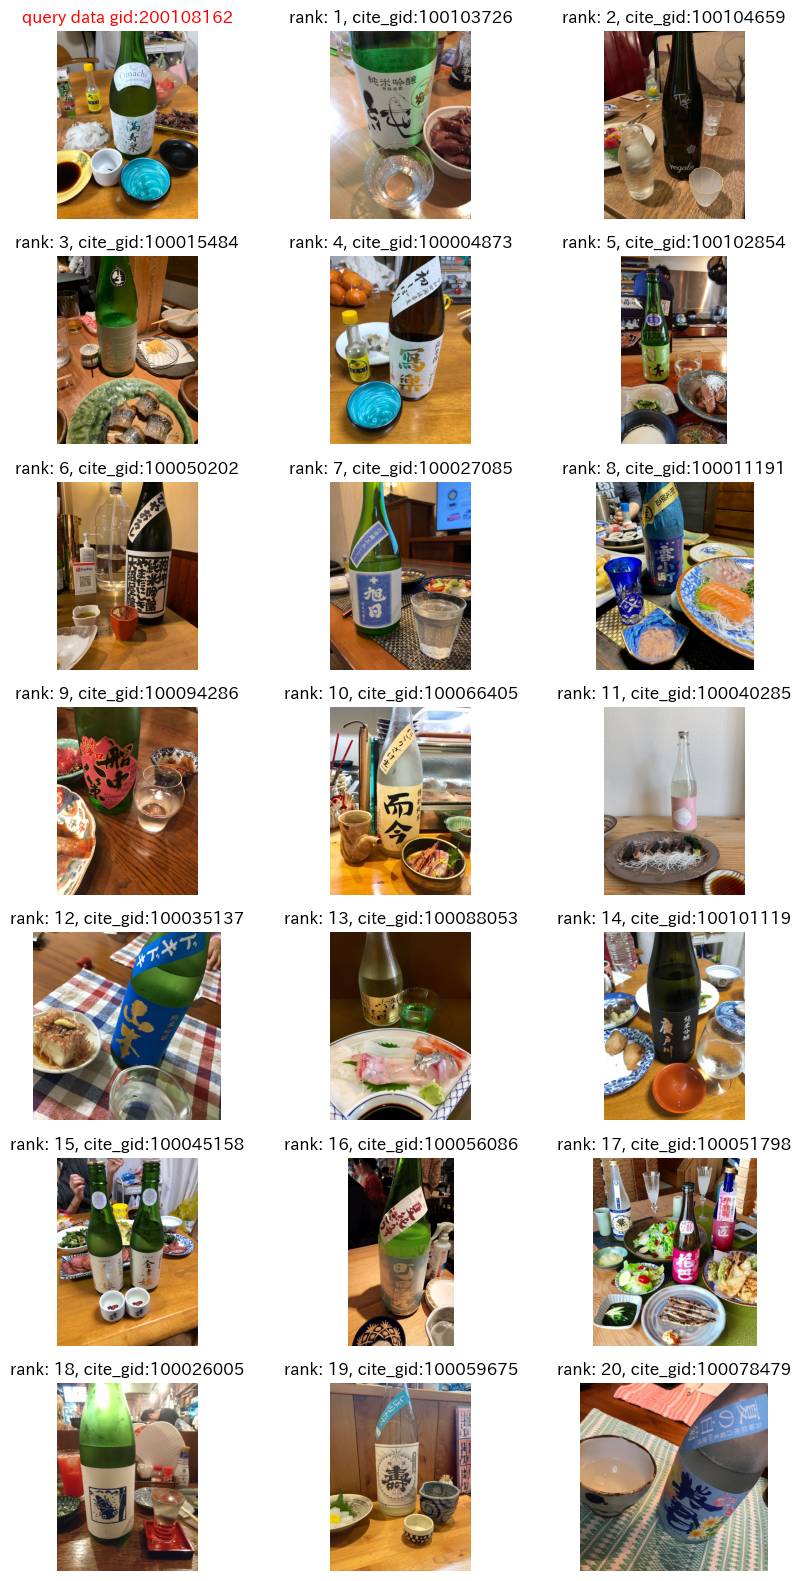

In [48]:
view_result_bygid(df_test, gid = 200108162)